# Import Packages

In [96]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import re
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

### Load in Pickeled DataFrame

In [277]:
tweets = pd.read_pickle('data/pickle_jar/cleaned2.pkl')

## Explore Data

In [9]:
# verify import
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1970258 entries, 0 to 1970257
Data columns (total 21 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   created_at               datetime64[ns]
 1   id                       int64         
 2   full_text                object        
 3   truncated                bool          
 4   in_reply_to_screen_name  object        
 5   is_quote_status          bool          
 6   retweet_count            int64         
 7   favorite_count           int64         
 8   lang                     object        
 9   retweeted_status         object        
 10  names                    object        
 11  screen_names             object        
 12  locations                object        
 13  follower_counts          int64         
 14  user_created_at          object        
 15  verified                 bool          
 16  statuses_counts          int64         
 17  location                 ob

In [11]:
# look at missing values
tweets.isna().sum()

created_at                       0
id                               0
full_text                        0
truncated                        0
in_reply_to_screen_name    1525932
is_quote_status                  0
retweet_count                    0
favorite_count                   0
lang                             0
retweeted_status           1970258
names                            0
screen_names                     0
locations                        0
follower_counts                  0
user_created_at                  0
verified                         0
statuses_counts                  0
location                   1889581
country                    1889581
hashtags                   1234431
withheld_in_countries      1970213
dtype: int64

## Prepare Data for Modeling

First, ground truth must be determined. To do this, hashtags are examined and parsed to find ones that clearly indicate a person's view on climate change. Then all tweets containing those tweets are labeled and prepared for modeling

In [15]:
# subset data that contains hashtags
df = tweets.dropna(subset=['hashtags'])

In [16]:
# create a list of all hashtags

hashtags_all = []
for row in df['hashtags']:
    for item in row:
        hashtags_all.append(item.lower())

In [22]:
# see hashtag count and sort by frequency
unique_hashtags = list(pd.Series(hashtags_all).value_counts().index)
# view top 5 for reference
print(unique_hashtags[:5])

['climatechange', 'globalwarming', 'climateaction', 'environment', 'climate']


In [23]:
# most common tags associated with sample of tweets presenting climate denial
denier_tags = ['climatechangeisfalse', 'climatechangenotreal', 'climatechangehoax', 
               'globalwarminghoax', 'tcot', 'ccot', 'tlot', 'pjnet', 'rednationrising', 'votered', 
               'libtard', 'libtards', 'maga']

# most common tags associated with sample of tweets indicating belief in climate science
believer_tags = ['climatechangeisreal', 'actonclimate', 'extinctionrebellion', 'climateemergency', 
                 'climateactionnow', 'capitalism', 'public_health', 'climateaction', 'humanityextinction',
                 'activism', 'noplanetb', 'savetheplanet']

In [24]:
# assign believer status to each row in the dataset
believe_series = []
for idx, row in df['hashtags'].iteritems():
    # set a count for matching tags in row
    believe = 0
    deny = 0 
    for tag in row:
        if tag.lower() in denier_tags:
            deny += 1
        elif tag.lower() in believer_tags:
            believe += 1
    
    # check that only one type of tag appears
    if (believe > 0) and (deny == 0):
        believe_series.append(1)
    elif (believe == 0) and (deny > 0):
        believe_series.append(0)
    else: # <-- if no matching tag OR if both appear, label as unknown using nonetype 
        believe_series.append(None)

### Add believer status to DataFrame

In [27]:
df = df.assign(believer = believe_series)

In [28]:
# subset dataframe to only include positive and negative cases
to_train = df.dropna(subset=['believer'])

### Create function to prep text for NLP processing

Remove unwanted character types, hashtags, usernames, and URLs. Remove line breaks and extra spaces

Tokenize, remove stopwords, lemmatize, join to string

In [53]:
# Instantiate nltk lemmatizer
lemmatizer = WordNetLemmatizer()

# create stop word list from default list, punctuation, and hashtags used to create classifcation params
stopwords_list = stopwords.words('english') + (list(string.punctuation) + 
                                               denier_tags + believer_tags + unique_hashtags[:100])

def re_clean(tweet):
    # regex cleaning
    tweet = tweet.lower()
    tweet = re.sub(r'[@][\w]+','', tweet)
    tweet = re.sub(r'[#]','', tweet)
    tweet = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', tweet)
    tweet = re.sub(r'\s{2,15}', ' ', tweet)
    tweet = re.sub(r'\n', ' ', tweet)
    tweet = re.sub(r'\s\s', ' ', tweet)
    tweet = tweet.strip()
    
    # tokenize, remove stop words, lemmatize
    tok = nltk.regexp_tokenize(tweet, r"([a-zA-Z]+(?:'[a-z]+)?)")
    toks = [word.lower() for word in tok if word.lower() not in stopwords_list]
    lemma = [lemmatizer.lemmatize(token) for token in toks]
    
    return ' '.join(lemma)

In [54]:
# create function to compare original text to cleaned text 
def check_cleaned(df, n = None):
    if not n:
        n = np.random.randint(0, len(df) - 1)
    print(f"ORIGINAL: \n{df.iloc[n]['full_text']} \n")
    print(f"CLEANED: \n{re_clean(df.iloc[n]['full_text'])}")
    
check_cleaned(to_train)

ORIGINAL: 
The Arctic Climate is Warming Dangerously Quickly: https://t.co/TNk4zCN87n
#climatechange #climateaction 
#environment 
#energy https://t.co/XEFqLr2Z4a 

CLEANED: 
warming dangerously quickly


### Clean Dataset text

In [55]:
# run function on each row
process_tweets = to_train['full_text'].apply(lambda x: re_clean(x))

In [56]:
# create target variable
y = to_train['believer']

## TF-IDF Vectorizer Modeling

In [61]:
# train test split with stratification to account for class imbalance
X_train, X_test, y_train, y_test = train_test_split(process_tweets, y, stratify=y)

In [62]:
# create dictionary holding class imbalnce
class_weights = dict(y.value_counts(normalize=True))

In [78]:
# create TD-IDF to RandomForest pipeline. Set fixed parameters
pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', RandomForestClassifier(class_weight=class_weights))])

In [79]:
# create grid search parameters
grid_params = {'clf__n_estimators': [100, 450, 800],
               'clf__criterion': ['gini', 'entropy'],
               'clf__max_depth': [None, 6, 10]}

In [80]:
# Instantiate gridsearch object 
gridsearch = GridSearchCV(pipeline, param_grid=grid_params, n_jobs = -1)
# fit to training set
gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        RandomForestClassifier(class_weight={0.0: 0.06617320889615642,
                                                                             1.0: 0.9338267911038436}))]),
             n_jobs=-1,
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [None, 6, 10],
                         'clf__n_estimators': [100, 450, 800]})

In [81]:
gridsearch.best_params_

{'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__n_estimators': 100}

In [82]:
# show pipeline accuracy score for best parameters
gridsearch.score(X_test, y_test)

0.9600250495772884

In [83]:
# generate predictions 
y_pred_train = gridsearch.predict(X_train)
y_pred = gridsearch.predict(X_test)

In [276]:
# compare F1 and Accuracy scores to check for overfitting 
print(f'Train Accuracy: {round(accuracy_score(y_train, y_pred_train), 4)}')
print(f'Train F1 Score: {round(f1_score(y_train, y_pred_train), 4)}')
print('-----'*6)
print(f'Test Accuracy:  {round(accuracy_score(y_test, y_pred), 4)}')
print(f'Test F1 Score:  {round(f1_score(y_test, y_pred), 4)}')

Train Accuracy: 0.9842
Train F1 Score: 0.9916
------------------------------
Test Accuracy:  0.96
Test F1 Score:  0.979


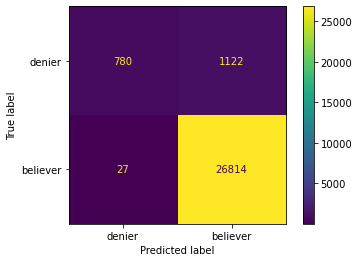

In [189]:
# visualize confusion matrix
con_mat = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(con_mat, display_labels=['denier', 'believer']).plot()


# Test on external dataset

A dataset from kaggle with labeled tweets as climate deniers or believers is imported for further validation of model

https://www.kaggle.com/edqian/twitter-climate-change-sentiment-dataset

In [193]:
val_df = pd.read_csv('data/twitter_sentiment_data.csv')

In [194]:
# re-map sentiment array to match existing model

cond_list = [val_df['sentiment'] == -1, 
             val_df['sentiment'] == 0,
             val_df['sentiment'] == 1,
             val_df['sentiment'] == 2]

choice_list = [0, None, val_df['sentiment'], None]

val_df['sentiment'] = np.select(cond_list, choice_list, 10)

In [195]:
# check for errors
val_df['sentiment'].value_counts()

1    22962
0     3990
Name: sentiment, dtype: int64

In [196]:
# check for matching tweets across datasets
count = 0
for id_ in val_df['tweetid']:
    if id_ in tweets['id']:
        count += 1
        print(id_)

In [197]:
# remove rows without usable ground truth
val_df_sub = val_df.dropna(subset = ['sentiment'])

# remove retweets
val_df_sub = val_df_sub[~val_df_sub['message'].str.startswith('RT ')]

In [199]:
# clean tweets
val_processed_text = val_df_sub['message'].apply(lambda x: re_clean(x))

In [200]:
# make predictions on validation data
val_predict = gridsearch.predict(val_processed_text)
y = val_df_sub['sentiment'].astype(int)

Accuracy Score :      0.8156
Validation F1 Score : 0.8977


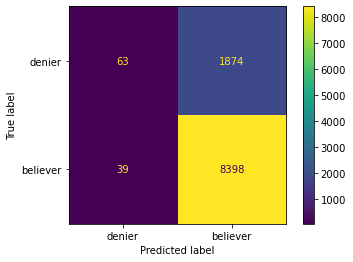

In [268]:
print(f"Accuracy Score :      {round(accuracy_score(y, val_predict), 4)}")
print(f"Validation F1 Score : {round(f1_score(y, val_predict), 4)}")

ConfusionMatrixDisplay(confusion_matrix(y, val_predict), display_labels=['denier', 'believer']).plot();

## Apply Classifier to remainder dataset

Run the entire dataset through the gridsearch pipeline to make predictions on each tweet

In [225]:
# remove irrelevant response tweets
tweets_final = tweets[tweets['in_reply_to_screen_name'].isna()]

In [226]:
# prepare tweets for model
tweets_final['clean_text'] = tweets_final['full_text'].apply(lambda x: re_clean(x)) 
tweets_final = tweets_final[tweets_final.clean_text.str.strip() != '']
tweets_final = tweets_final[tweets_final.clean_text.str.strip() != ' ']
# run text through model
tweets_final['believer_pred'] = gridsearch.predict(tweets_final['clean_text'])

/Users/browz/opt/anaconda3/envs/ds01/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [260]:
tweets_final['believer_pred'].value_counts(normalize=True)

1.0    0.989312
0.0    0.010688
Name: believer_pred, dtype: float64

In [243]:
# sanity check on predictions
def check_pred(df, n=None):
    if n == None:
        n = np.random.randint(0,len(df)-1)
    print(df.iloc[n]['full_text'], '\n', df.iloc[n]['believer_pred'])
    print(f'https://twitter.com/{df.iloc[n]["screen_names"]}/status/{df.iloc[n]["id"]}')

In [267]:
check_pred(tweets_final[tweets_final['believer_pred']==0])

MAKE IT STOP! Solar energy is trying to force conformity https://t.co/y0aOyOMDci #tcot #tlot #climatechange #solar 
 0.0
https://twitter.com/SolarSecrets/status/1019344789660151809
